In [1]:
from dotenv import load_dotenv
import os
print(load_dotenv('../.env'))

True


## Graph

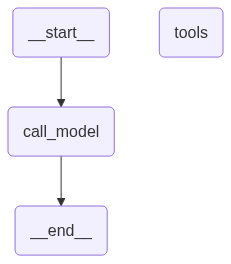

================================ Human Message =================================

what's (3 + 5) x 12?
================================== Ai Message ==================================
Tool Calls:
  add (call_uBqcZCUpdQu1jAPlGURkuYkL)
 Call ID: call_uBqcZCUpdQu1jAPlGURkuYkL
  Args:
    a: 3
    b: 5
================================= Tool Message =================================
Name: add

8
================================== Ai Message ==================================
Tool Calls:
  multiply (call_pnhZqly2GiglSfpeHN7bJZJP)
 Call ID: call_pnhZqly2GiglSfpeHN7bJZJP
  Args:
    a: 8
    b: 12
================================= Tool Message =================================
Name: multiply

96
================================== Ai Message ==================================

(3 + 5) equals 8, and 8 × 12 is 96. 

So, (3 + 5) × 12 = 96.


In [3]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
import os
from IPython.display import Image, display

model = ChatOpenAI(model=os.environ["OPENAI_MODEL"])
client = MultiServerMCPClient(
    {
        "math": {
            "command": "python",
            "args": [f"{os.getcwd()}/math_mcp_stdio.py"],
            "transport": "stdio",
        }
    }
)
tools = await client.get_tools()
model_with_tools = model.bind_tools(tools)

# Create ToolNode
tool_node = ToolNode(tools)

def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

# Define call_model function
async def call_model(state: MessagesState):
    messages = state["messages"]
    response = await model_with_tools.ainvoke(messages)
    return {"messages": [response]}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model",
    should_continue,
)
builder.add_edge("tools", "call_model")

# Compile the graph
graph = builder.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# Test the graph
messages = await graph.ainvoke(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 12?"}]}
)

for m in messages['messages']:
    m.pretty_print()